# Frequency analysis

$$
\dot T = \kappa \, \nabla^2 T + f
$$


$$
T = \tilde T \, e^{iwt}
$$


$$
iw\, \tilde T - \kappa \, \nabla^2 \tilde T = f
$$

$$
\int iw\, \tilde T \, v\, dx - \kappa  \int \nabla^2 \tilde T v\, dx = \int f v\, dx
$$

$$
 +\kappa \int \nabla \tilde T \nabla v\, dx  - \kappa \int \nabla T v \, ds +  \int iw\, \tilde T \, v\, dx = \int f v\, dx
$$

Longueur de la zone chauffé: $L=1$

In [97]:
import dolfin as df
import matplotlib.pyplot as plt

import mshr

import numpy as np

In [98]:
# Geometry and Mesh
isolation_depth = .5
isolation_thickness = .06
house_half_size = 4
domain_size = 12

domain = mshr.Rectangle(df.Point(-domain_size, -1.5*domain_size), df.Point(house_half_size, 0.))
isolation = mshr.Rectangle(df.Point(0.0, -isolation_depth), df.Point(isolation_thickness, .0))

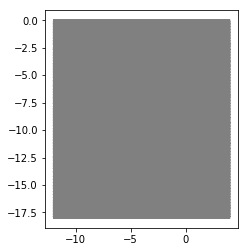

In [99]:
mesh = mshr.generate_mesh(domain, 105)

df.plot(mesh);

## boundary conditions

In [100]:
class SurfaceExt(df.SubDomain):
    def inside(self, x, on_boundary):
        surface = on_boundary and\
                  df.near(x[1], 0, df.DOLFIN_EPS) and x[0]<df.DOLFIN_EPS
        return surface
    
class SurfaceInt(df.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and\
               df.near(x[1], 0, df.DOLFIN_EPS) and x[0]>isolation_thickness-df.DOLFIN_EPS

class DomainBoundary(df.SubDomain):    
    def inside(self, x, on_boundary):

        left_side = df.near(x[0], -domain_size, df.DOLFIN_EPS)
        bottom_side = df.near(x[1], -1.5*domain_size, df.DOLFIN_EPS)
        return left_side or bottom_side
    
surface_ext = SurfaceExt()
surface_int = SurfaceInt()
domain_bound = DomainBoundary()

# MeshFunctions marking boundary and cell parts
boundary_markers = df.FacetFunction("size_t", mesh)
cell_markers = df.CellFunction("size_t", mesh)

markers = df.MeshFunction('size_t', mesh, 2, mesh.domains())

In [101]:
boundary_markers.set_all(0)
surface_ext.mark(boundary_markers, 1)
surface_int.mark(boundary_markers, 2)
domain_bound.mark(boundary_markers, 3)

# boundary_markers.array())

In [102]:
dx = df.Measure('dx', domain=mesh, subdomain_data=markers)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

https://fenics.readthedocs.io/projects/dolfin/en/2017.2.0/demos/cahn-hilliard/python/demo_cahn-hilliard.py.html

In [103]:
P1 = df.FiniteElement("Lagrange", mesh.ufl_cell(), 2)
W = df.FunctionSpace(mesh, P1*P1)

In [104]:
(u_r, u_i) = df.TrialFunctions(W)
(v_r, v_i) = df.TestFunctions(W)

grad = df.grad
kappa = 1e-6
w = 2*np.pi / (24 * 60 * 60 * 365)

a_r = kappa*( df.inner(grad(u_r),grad(v_r))*df.dx - df.inner(grad(u_i),grad(v_i))*df.dx )\
      - w * u_i*v_i*df.dx
a_i = kappa*( df.inner(grad(u_r),grad(v_i))*df.dx + df.inner(grad(u_i),grad(v_r))*df.dx )\
      + w * u_r*v_r*df.dx


a = a_i + a_r

In [105]:
# Define boundary condition

bc_ext_amp = df.DirichletBC(W.sub(0), df.Constant(1.0), surface_ext)
bc_ext_phase = df.DirichletBC(W.sub(1), df.Constant(.0), surface_ext)

bcs = [bc_ext_amp, bc_ext_phase]

In [106]:
# Define input data

f = df.Constant(.0)

L = f*v_r*df.dx + f*v_i*df.dx

In [107]:
# Solve problem
u = df.Function(W)
df.solve(a == L, u, bcs)

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [108]:
uu = u.vector()

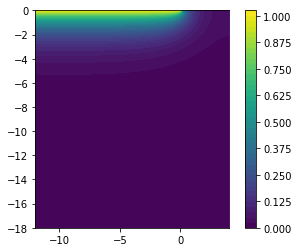

In [109]:
ax = df.plot( df.dot(u,u) )
plt.colorbar(ax);

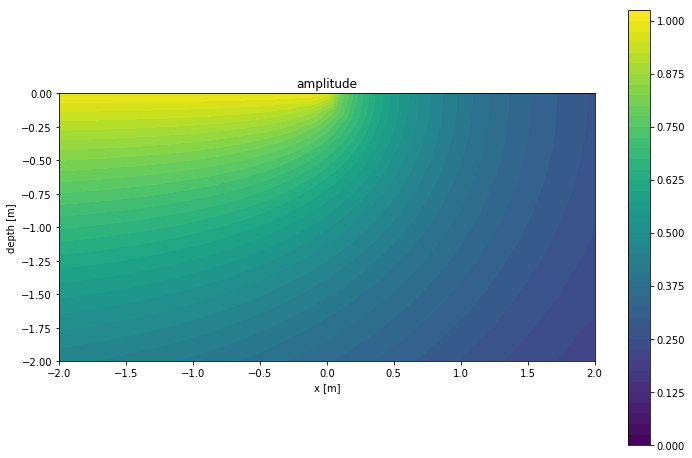

In [110]:
plt.figure(figsize=(12, 8))
ax = df.plot( df.sqrt( u.sub(1)**2 + u.sub(0)**2 ))
plt.xlabel('x [m]');
plt.ylabel('depth [m]');
plt.xlim([-2, 2]); plt.ylim([-2, 0]);
plt.colorbar(ax); plt.title('amplitude')


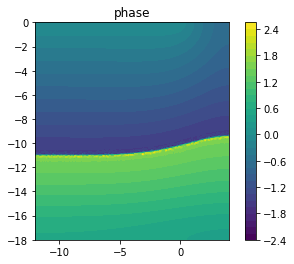

In [111]:
ax = df.plot( df.atan(u.sub(1)/u.sub(0)) )
plt.colorbar(ax); plt.title('phase');

In [341]:
import numpy as np

In [342]:
x_plot = np.linspace(0, 6, 50)
sol_complex = np.array([u([x, 0]) for x in x_plot])

In [343]:
amplitude = np.sqrt( np.sum(sol_complex**2, axis=1) )
phase = np.arctan2(sol_complex[:, 1], sol_complex[:, 0])

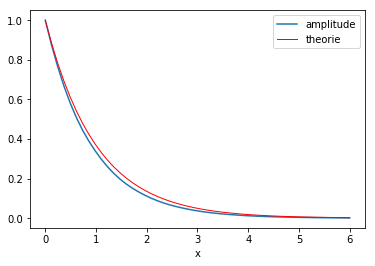

In [344]:
plt.plot(x_plot, amplitude, label="amplitude")
#plt.plot(x_plot, phase, label="phase")
plt.plot(x_plot, np.exp(-x_plot), 'r', linewidth=1, label="theorie")
plt.legend(); plt.xlabel('x');

## Post process

In [ ]:
# Length of the interior boundary:
L_int = df.assemble( df.Constant(1.)*ds(2) )
print(L_int)

In [ ]:
# Flux chaleur moyen vers le sol:
df.assemble( df.Dx(u, 1)*ds(2) )/L_int

In [ ]:
# Flux sortant de domain
n = df.FacetNormal(mesh)
flux_1 = df.assemble(df.dot(df.grad(u), n)*ds(1))
flux_1